In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

print('Imports Complete')

Imports Complete


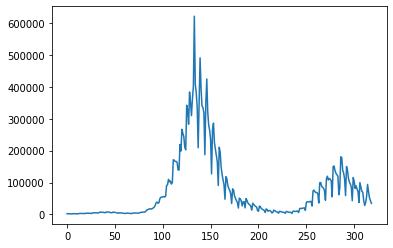

In [2]:
from pandas import read_csv

dataframe = read_csv('covid_19_res.csv', usecols=[12], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

plt.plot(dataset)

In [3]:
# fix random seed for reproducibility
tf.random.set_seed(7)

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [4]:
# normalize the dataset
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [5]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 20

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [6]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [13]:
model_gru = Sequential()
model_gru.add(GRU(4, return_sequences=True,input_shape=(look_back, 1)))
model_gru.add(GRU(units=30, return_sequences=True))
model_gru.add(GRU(units=30))
model_gru.add(Dense(units=1))

model_gru.compile(loss='mae', optimizer='adam')
model_gru.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 20, 4)             84        
                                                                 
 gru_4 (GRU)                 (None, 20, 30)            3240      
                                                                 
 gru_5 (GRU)                 (None, 30)                5580      
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 8,935
Trainable params: 8,935
Non-trainable params: 0
_________________________________________________________________


In [14]:
# fit network
gru_history = model_gru.fit(trainX, trainY, epochs=10,verbose=1)


Epoch 1/10
6/6 [==============================] - 5s 9ms/step - loss: 0.0829
Epoch 2/10
6/6 [==============================] - 0s 10ms/step - loss: 0.0530
Epoch 3/10
6/6 [==============================] - 0s 9ms/step - loss: 0.0437
Epoch 4/10
6/6 [==============================] - 0s 9ms/step - loss: 0.0402
Epoch 5/10
6/6 [==============================] - 0s 10ms/step - loss: 0.0385
Epoch 6/10
6/6 [==============================] - 0s 10ms/step - loss: 0.0385
Epoch 7/10
6/6 [==============================] - 0s 10ms/step - loss: 0.0372
Epoch 8/10
6/6 [==============================] - 0s 10ms/step - loss: 0.0363
Epoch 9/10
6/6 [==============================] - 0s 11ms/step - loss: 0.0371
Epoch 10/10
6/6 [==============================] - 0s 10ms/step - loss: 0.0368


In [16]:
# make predictions
trainPredict = model_gru.predict(trainX)
testPredict = model_gru.predict(testX)

In [17]:
from sklearn.metrics import mean_squared_error

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 44676.65 RMSE
Test Score: 27212.46 RMSE


In [18]:
train = pd.read_csv('covid_19_res.csv', encoding='utf-8')
train.head()
train.index = pd.to_datetime(train['서울시 기준일'], format='%Y.%m.%d.%h',errors='ignore')
time = train.index

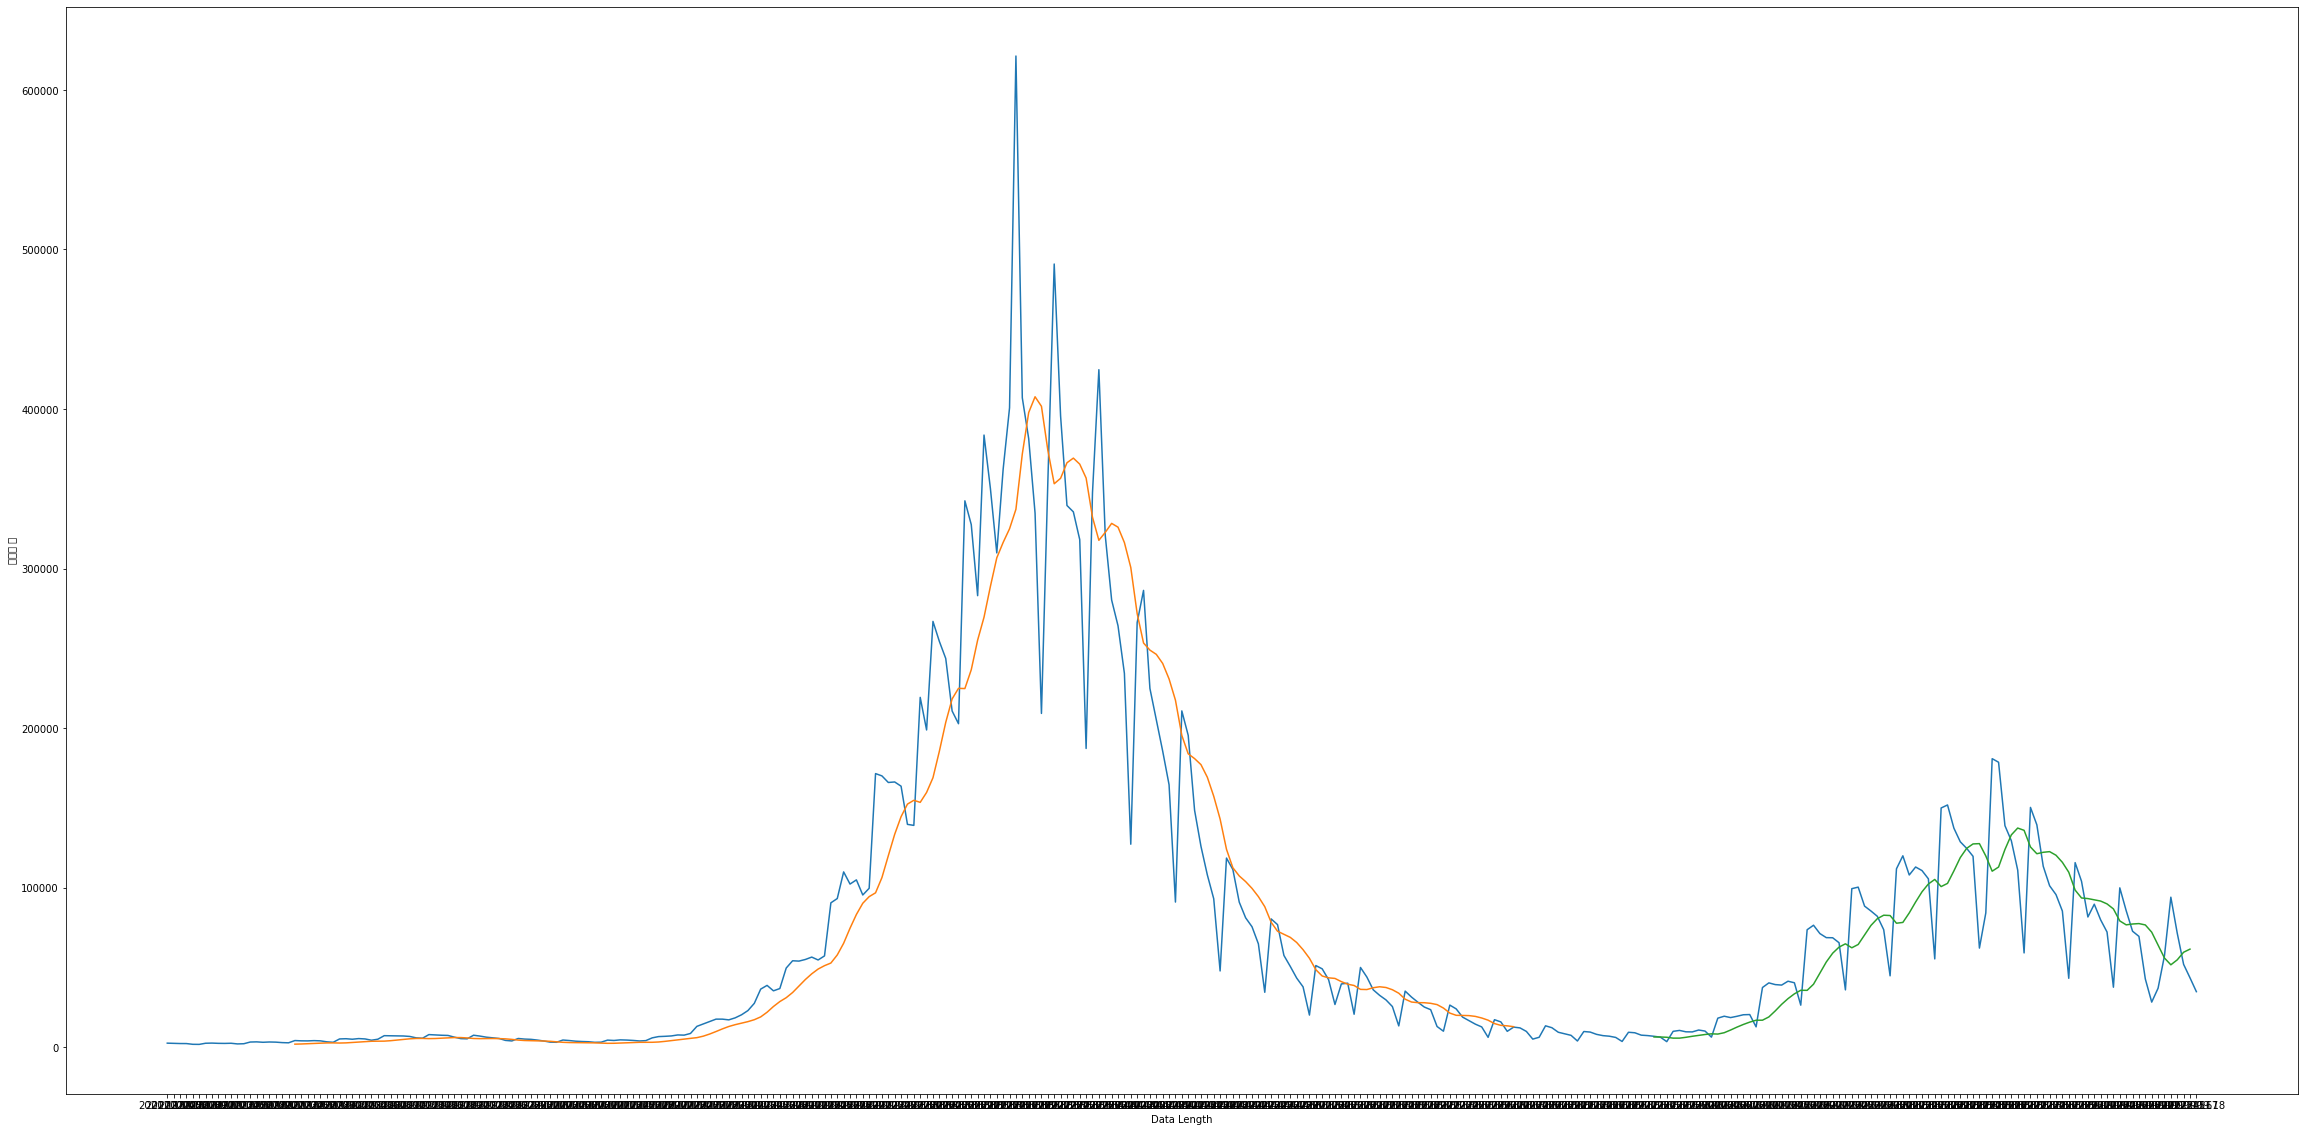

In [19]:

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


korea_TrainPredict = trainPredictPlot
korea_TestPredict = testPredictPlot
# plot baseline and predictions
plt.figure(figsize=(40,20))
plt.plot(time,scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)


plt.xlabel("Data Length")
plt.ylabel("확진자 수")


plt.show()